###### Reinforcement Learning - VG part

umu-id: anth2786

The code is based on code from:
- https://colab.research.google.com/github/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb
<br><br>
The lab task starts with the headline "Lab task" below<br>



###### Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

#try:
#    # %tensorflow_version only exists in Colab.
#    %tensorflow_version 2.x
#    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
#    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
#    IS_COLAB = True
#except Exception:
#    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.config.list_physical_devices('GPU'):
#    print("No GPU was detected. CNNs can be very slow without a GPU.")
#    if IS_COLAB:
#        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

###### Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [2]:
import gym

Let's list all the available environments:

In [3]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [4]:
env = gym.make('CartPole-v1')

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [5]:
env.seed(42)
obs = env.reset()

Observations vary depending on the environment. In this case it is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

In [6]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment).

**Warning**: some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify `mode="rgb_array"`. In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like [Xvfb](http://en.wikipedia.org/wiki/Xvfb). On Debian or Ubuntu:

```bash
$ apt update
$ apt install -y xvfb
```

You can then start Jupyter using the `xvfb-run` command:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

Alternatively, you can install the [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) Python library which wraps Xvfb:

```bash
python3 -m pip install -U pyvirtualdisplay
```

And run the following code:

In [7]:
#try:
#    import pyvirtualdisplay
#    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
#except ImportError:
#    pass

In [8]:
#env.render()

In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [9]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [10]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

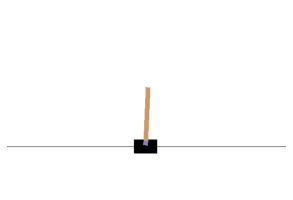

In [11]:
plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [12]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right.

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [13]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

Saving figure cart_pole_plot


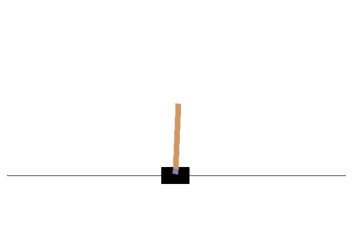

In [14]:
plot_environment(env)
save_fig("cart_pole_plot")

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [15]:
reward

1.0

When the game is over, the environment returns `done=True`:

In [16]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [17]:
info

{}

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True`), you should reset the environment before you continue to use it.

In [18]:
if done:
    obs = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

###### A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [19]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [20]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 68 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode:

In [21]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation:

In [22]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [23]:
plot_animation(frames)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

###### Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small function that will run the model to play one episode, and return the frames so we can display an animation:

In [25]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

Now let's look at how well this randomly initialized policy network performs:

In [26]:
frames = render_policy_net(model)
plot_animation(frames)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

We can make the same net play in 50 different environments in parallel (this will give us a diverse training batch at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments.

In [27]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.094

In [28]:
frames = render_policy_net(model)
plot_animation(frames)

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own. One that does not wobble as much.

###### Policy Gradients

To train this neural network we will need to define the target probabilities `y`. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions in good episodes slightly more likely, while actions in bad episodes are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients (we will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be):

In [29]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [30]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [31]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [32]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [33]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [34]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [35]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [37]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 35, mean rewards: 56.6

Exception ignored in: <function Viewer.__del__ at 0x0000000040362820>
Traceback (most recent call last):
  File "c:\python38\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "c:\python38\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "c:\python38\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "c:\python38\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "c:\python38\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000000004D5660E0; to 'Win32Window' at 0x000000003FF31C70>


Iteration: 149, mean rewards: 195.3

In [38]:
frames = render_policy_net(model)
plot_animation(frames)

###### Markov Chains

In [39]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


###### Markov Decision Process

Let's define some transition probabilities, rewards and possible actions. For example, in state s0, if action a0 is chosen then with proba 0.7 we will go to state s0 with reward +10, with probability 0.3 we will go to state s1 with no reward, and with never go to state s2 (so the transition probabilities are `[0.7, 0.3, 0.0]`, and the rewards are `[+10, 0, 0]`):

In [40]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

###### Q-Value Iteration

In [41]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [42]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown

In [43]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [44]:
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

The optimal policy for this MDP, when using a discount factor of 0.90, is to choose action a0 when in state s0, and choose action a0 when in state s1, and finally choose action a1 (the only possible action) when in state s2.

Let's try again with a discount factor of 0.95:

In [45]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [46]:
gamma = 0.95  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [47]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [48]:
np.argmax(Q_values, axis=1)

array([0, 2, 1], dtype=int64)

Now the policy has changed! In state s1, we now prefer to go through the fire (choose action a2). This is because the discount factor is larger so the agent values the future more, and it is therefore ready to pay an immediate penalty in order to get more future rewards.

###### Q-Learning

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

We will need to simulate an agent moving around in the environment, so let's define a function to perform some action and get the new state and a reward:

In [49]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

We also need an exploration policy, which can be any policy, as long as it visits every possible state many times. We will just use a random policy, since the state space is very small:

In [50]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Now let's initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [51]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown

In [52]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [53]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1], dtype=int64)

Saving figure q_value_plot


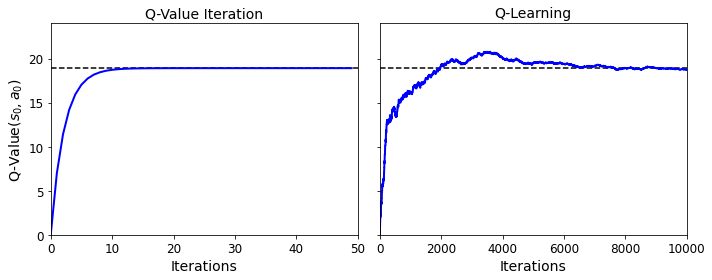

In [54]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")

## Lab task

<b>Task: </b>Run DQL, Double-DQN and Dueling-DQN with performance measures. Analysis of the performance metrics in the end<br><br>
New code besides Gerons are marked ***

###### Deep Q-Network

Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome):

In [55]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [56]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

We will also need a replay memory. It will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that:

In [57]:
from collections import deque

replay_memory = deque(maxlen=2000)

And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: `[obs, actions, rewards, next_obs, dones]`.

In [58]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [59]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:

**Note**: the first 3 releases of the 2nd edition were missing the `reshape()` operation which converts `target_Q_values` to a column vector (this is required by the `loss_fn()`).

In [60]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

And now, let's train the model!

In [61]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

# *** New code
maxrewards = []
maxR = 0
minbuffer = []
nrinminbuffer = 10
minbatchrewards = []



In [62]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    
    # *** New code
    if step > maxR: 
        maxR = step        
    maxrewards.append(maxR)
    minbuffer.append(step)
    minbatchrewards.append(np.min(minbuffer[-10:]))
    
    if step > best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 19, eps: 0.0108

Saving figure dqn_rewards_plot


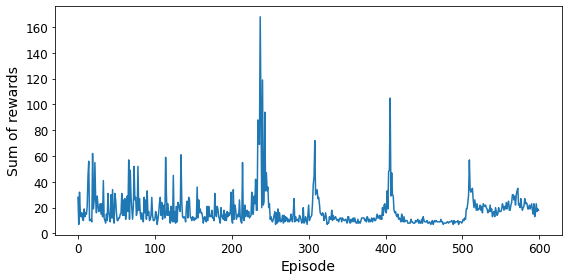

In [63]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [64]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

Average: [20.37 20.46 20.52 20.66 20.69 20.79 20.93 21.01 21.11 21.21]
Minimum: [19, 18, 15, 15, 13, 13, 13, 13, 13, 13]


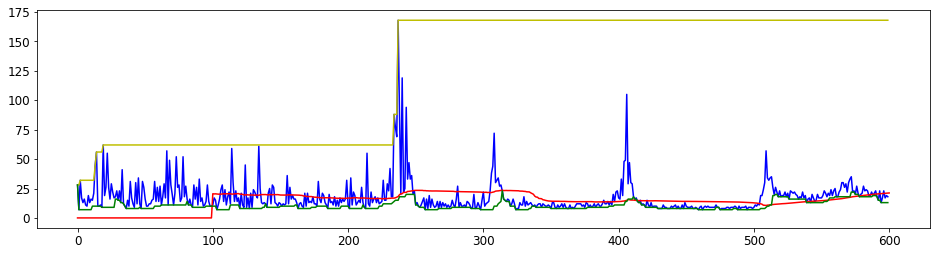

In [65]:
plt.figure(figsize=(16, 4))
plt.plot(rewards,"b")
size = 100
y_av1 = running_mean(rewards, N=size)
y_av = np.insert(y_av1, np.repeat(0,100), 0)
#y_av = np.concatenate(y_av1,y_av2)

plt.plot(y_av,"r") 
plt.plot(maxrewards,"y") 
plt.plot(minbatchrewards,"g") 
    
print("Average:",y_av[-10:])
print("Minimum:",minbatchrewards[-10:])

In [66]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

###### Double DQN

In [67]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [68]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [69]:
replay_memory = deque(maxlen=2000)

In [70]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

# *** New code
maxrewards = []
maxR = 0
minbuffer = []
nrinminbuffer = 10
minbatchrewards = []


for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    
    # *** New code
    if step > maxR: 
        maxR = step
    maxrewards.append(maxR)
    minbuffer.append(step)
    minbatchrewards.append(np.min(minbuffer[-10:]))

    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 50 == 0:
        target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode > 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 49, eps: 0.0100

Saving figure double_dqn_rewards_plot


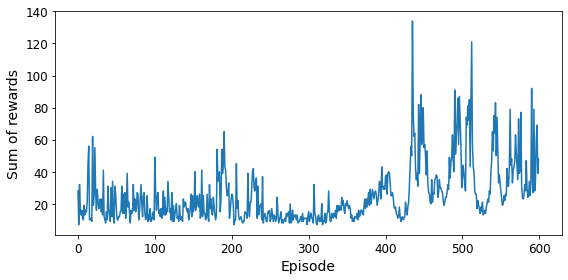

In [71]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [72]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

Average: [42.08 41.93 41.58 41.66 41.08 40.86 40.59 40.56 40.37 40.55]
Minimum: [24, 24, 24, 24, 24, 25, 25, 25, 27, 27]


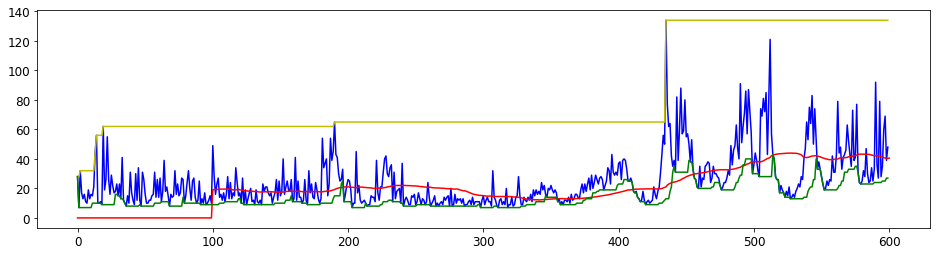

In [73]:
plt.figure(figsize=(16, 4))
plt.plot(rewards,"b")
size = 100
y_av1 = running_mean(rewards, N=size)
y_av = np.insert(y_av1, np.repeat(0,100), 0)
#y_av = np.concatenate(y_av1,y_av2)

plt.plot(y_av,"r") 
plt.plot(maxrewards,"y") 
plt.plot(minbatchrewards,"g") 
    
print("Average:",y_av[-10:])
print("Minimum:",minbatchrewards[-10:])

In [74]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

###### Dueling Double DQN

In [75]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [76]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [77]:
replay_memory = deque(maxlen=2000)

In [78]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []

# *** New code
maxrewards = []
maxR = 0
minbuffer = []
nrinminbuffer = 10
minbatchrewards = []

best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)

    # *** New code
    if step > maxR: 
        maxR = step
    maxrewards.append(maxR)
    minbuffer.append(step)
    minbatchrewards.append(np.min(minbuffer[-10:]))
    
    # print("\rmin10rewards (",episode,") :",step,"  ",min10rewards, "array:",minbuffer)
    
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 74, eps: 0.0100

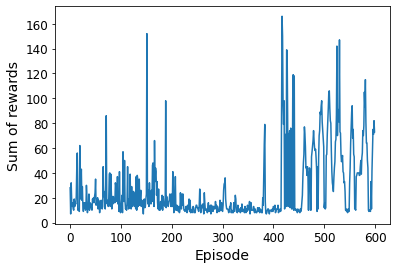

In [79]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [80]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


Average: [54.58 53.93 53.37 52.61 52.09 51.68 51.62 51.59 51.75 51.87]
Minimum: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


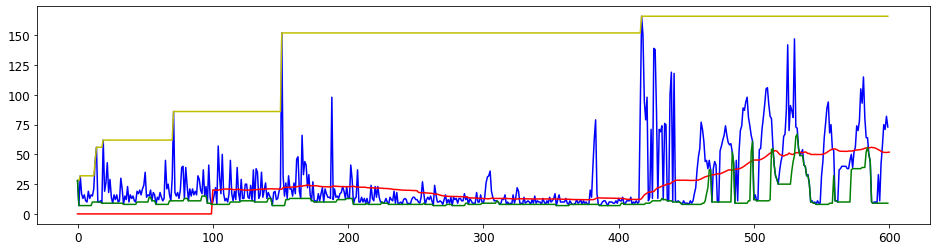

In [81]:
plt.figure(figsize=(16, 4))
plt.plot(rewards,"b")
size = 100
y_av1 = running_mean(rewards, N=size)
y_av = np.insert(y_av1, np.repeat(0,100), 0)
#y_av = np.concatenate(y_av1,y_av2)

plt.plot(y_av,"r") 
plt.plot(maxrewards,"y") 
plt.plot(minbatchrewards,"g") 
    
print("Average:",y_av[-10:])
print("Minimum:",minbatchrewards[-10:])

In [82]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

#### Try a different decay

In [83]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []

# *** New code
maxrewards = []
maxR = 0
minbuffer = []
nrinminbuffer = 10
minbatchrewards = []

best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 200, 0.1)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)

    # *** New code
    if step > maxR: 
        maxR = step
    maxrewards.append(maxR)
    minbuffer.append(step)
    minbatchrewards.append(np.min(minbuffer[-10:]))
    
    # print("\rmin10rewards (",episode,") :",step,"  ",min10rewards, "array:",minbuffer)
    
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 174, eps: 0.100

In [84]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


Average: [160.12 159.8  158.88 159.64 159.84 160.52 160.8  159.4  161.12 161.8 ]
Minimum: [149, 149, 147, 147, 147, 147, 147, 147, 147, 147]


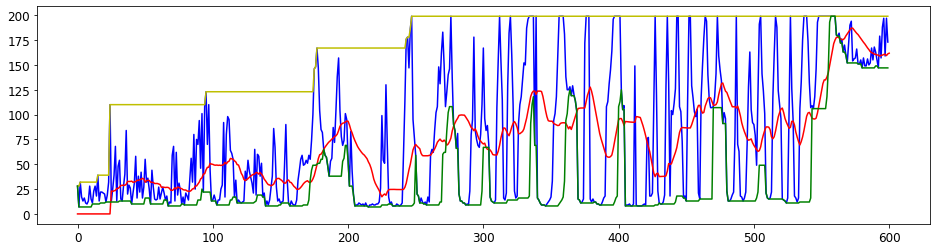

In [85]:
plt.figure(figsize=(16, 4))
plt.plot(rewards,"b")
size = 25
y_av1 = running_mean(rewards, N=size)
y_av = np.insert(y_av1, np.repeat(0,size), 0)
#y_av = np.concatenate(y_av1,y_av2)

plt.plot(y_av,"r") 
plt.plot(maxrewards,"y") 
plt.plot(minbatchrewards,"g") 
    
print("Average:",y_av[-10:])
print("Minimum:",minbatchrewards[-10:])

In [87]:
env.seed(42)
state = env.reset()

frames = []

for step in range(50):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

In [88]:
env.close()

#### The best model fom G part

In [89]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import os
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from numpy import argmax

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# For this Lab
import random
import gym

TensorFlow version: 2.3.1
Keras version: 2.4.0


In [90]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [91]:
# Inspired by RL researchers and written by Kalle Prorok for a Deep Learning Course
# Umeå Sweden 2019

# A set of parameters that is working well
EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 10     # discretization steps per state variable (aviod odd numbers), org val = 10

# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state

-------- Parameters ------------
EPISODES: 15000
EPSILON: 1
GAMMA: 0.98
LEARNING_RATE: 0.5
DISCRETE_STEPS: 20
Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 160000 x 2
0,10.0,0.5,1.0
500,46.0,0.4,0.8
1000,16.0,0.3333333333333333,0.6666666666666666
1500,96.0,0.2857142857142857,0.5714285714285714
2000,101.0,0.25,0.5
2500,24.0,0.2222222222222222,0.4444444444444444
3000,77.0,0.2,0.4
3500,60.0,0.18181818181818182,0.36363636363636365
4000,15.0,0.16666666666666666,0.3333333333333333
4500,195.0,0.15384615384615385,0.3076923076923077
5000,121.0,0.14285714285714285,0.2857142857142857
5500,215.0,0.13333333333333333,0.26666666666666666
6000,163.0,0.125,0.25
6500,155.0,0.11764705882352941,0.23529411764705882
7000,43.0,0.1111111111111111,0.2222222222222222
7500,337.0,0.10526315789473684,0.21052631578947367
8000,330.0,0.1,0.2
8500,500.0,0.09523809523809523,0.19047619047619047
9000,66.0,0.09090909090909091,0.181818181818

vector nr: 76229  values:  48.3264177855313 , 48.105398487284106
vector nr: 76230  values:  48.3030071466133 , 48.223137022165204
vector nr: 76231  values:  48.284384755444314 , 48.31976723800978
vector nr: 76232  values:  34.093842707996195 , 7.841646058748375
vector nr: 76249  values:  48.55555061053716 , 48.25522882372031
vector nr: 76250  values:  48.38128581357293 , 48.39310355080326
vector nr: 76251  values:  47.52570363888398 , 48.39792638618161
vector nr: 76252  values:  30.8509959600966 , 1.6830594345627052
vector nr: 76269  values:  46.80723437017252 , 48.33804168092586
vector nr: 76270  values:  47.19139063812691 , 48.305681774085144
vector nr: 76271  values:  44.051892616345945 , 45.407341409256304
vector nr: 76272  values:  12.205690585675637 , 0.37803240829081514
vector nr: 76289  values:  26.788563125708976 , 6.8502781346823625
vector nr: 76290  values:  41.73719592415238 , 46.748308185441374
vector nr: 76291  values:  32.9298953236504 , 39.46283424045195
vector nr: 7629

vector nr: 108170  values:  38.01626744040755 , 35.87071697329143
vector nr: 108171  values:  34.952121631180496 , 37.81419954016489
vector nr: 108172  values:  0.8975684339681083 , 2.423905781589147
vector nr: 108189  values:  21.22384698560772 , 1.5445299121770062
vector nr: 108190  values:  32.52015213634634 , 31.18245853525227
vector nr: 108191  values:  29.630325217916194 , 31.597278641242536
vector nr: 108192  values:  11.063854596800486 , 3.4045771441541177
vector nr: 108209  values:  20.59198481887741 , 3.114255469424461
vector nr: 108210  values:  27.982109263738725 , 27.964051001419122
vector nr: 108211  values:  25.455234135959497 , 26.16146643859714
vector nr: 108212  values:  4.859428457197163 , 18.671908374226796
vector nr: 108229  values:  15.384034583350482 , 0.8991170744300532
vector nr: 108230  values:  25.621441835114435 , 24.512760913013786
vector nr: 108231  values:  21.392047269969215 , 22.9229885114083
vector nr: 108232  values:  4.999243350372205 , 20.1723624161

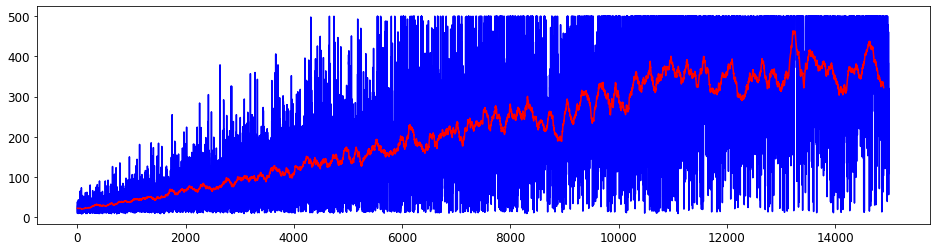

In [92]:
    # A set of parameters that is working well
    EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
    DISCRETE_STEPS = 20     # discretization steps per state variable (aviod odd numbers), org val = 10
    
    # Start with high EPSILON (and decreas in the code)
    EPSILON        = 1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
    # These are "earlier best" and changed per run
    GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9   
    LEARNING_RATE  = 0.5    # Learning rate, org val = 0.1

    GAMMA          = 0.98
    
    print("-------- Parameters ------------")

    print("EPISODES:",EPISODES)
    print("EPSILON:",EPSILON)
    print("GAMMA:",GAMMA)
    print("LEARNING_RATE:",LEARNING_RATE)
    print("DISCRETE_STEPS:",DISCRETE_STEPS)
    
        
        
    # (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
    average_cumulative_reward = 0.0

    episode_reward = np.zeros(EPISODES)
    # Create the Gym environment (CartPole)
    env = gym.make('CartPole-v1')

    print('Action space is:', env.action_space)
    print('Observation space is:', env.observation_space)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

    # Geron code
    alpha0 = 0.05
    decay = 0.005
    # gamma = 0.9
    state = 0
    # *** less epsilon decay
    decay = 0.0005

    
    # *** New code
    maxrewards = []
    maxR = 0
    minbuffer = []
    nrinminbuffer = 10
    minbatchrewards = []    

    # Loop over episodes
    # Code to make the training animated
    # https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
    for i in range(EPISODES):
                        
        # Tomas code
        state4D = env.reset()
        state = make_state(state4D)

        terminate = False
        cumulative_reward = 0.0

        # Loop over time-steps
        while not terminate:
            # Compute what the greedy action for the current state is
            qvalues = qtable[state]
            greedy_action = argmax(qvalues)

            # Sometimes, the agent takes a random action, to explore the environment
            # *** Use Epsilon-greedy with increasing probablility to choose max
            EP = EPSILON / (1 + i * decay)            
            if random.random() < EP:
                action = random.randrange(2)
            else:
                action = greedy_action

            
            
            # Perform the action
            next_state, reward, terminate, info = env.step(action)  # info is ignored
            next_state = make_state(next_state)
        
            # Show the simulated environment. A bit difficult to make it work.            
            # env.render()

            # Update the Q-Table - *** UPDATED CODE ***
            LR = LEARNING_RATE / (1 + i * decay)            
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += LR * td_error
            
            # Update statistics
            cumulative_reward += reward
            state = next_state

        # store reward for every episode
        episode_reward[i] = cumulative_reward

        # *** New code
        if cumulative_reward > maxR: 
            maxR = cumulative_reward
        maxrewards.append(maxR)
        minbuffer.append(cumulative_reward)
        minbatchrewards.append(np.min(minbuffer[-500:]))
    
        # Adapt epsilon and learning rate here

        # Per-episode statistics
        if ((i % 500)==0):
          print(i, cumulative_reward, LR, EP, sep=',')

    print("---->>>> Check the Q-table (if a vector have 0.0 values, the it is not written below)")
    qvaluecount = 0
    cnt = 0
    for a,b in qtable:
        cnt = cnt + 1
        if a != 0.0 and b != 0.0:
            print ("vector nr:",cnt," values: ",a,",",b)
            qvaluecount = qvaluecount + 1
            
    print("Number of vectors in the q table:" , qvaluecount)
    
    
    print("-------- Done ------------")
    
    # Plot the results from a training run
    plt.figure(figsize=(16, 4))
    plt.plot(episode_reward,"b")
    y_av = running_mean(episode_reward, N=100)
    plt.plot(y_av,"r") 
    
    print("Average:",y_av)
    

Average: [328.81 329.2  329.13 327.86 325.08 323.25 325.14 324.89 323.99 322.46]
Minimum: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]


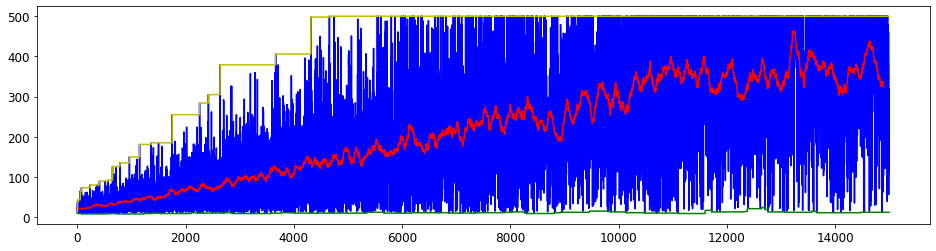

In [93]:
plt.figure(figsize=(16, 4))
#plt.plot(rewards,"b")
plt.plot(episode_reward,"b")

size = 100
y_av1 = running_mean(episode_reward, N=size)
y_av = np.insert(y_av1, np.repeat(0,size), 0)

plt.plot(y_av1,"r") 
plt.plot(maxrewards,"y") 
plt.plot(minbatchrewards,"g") 
    
print("Average:",y_av1[-10:])
print("Minimum:",minbatchrewards[-10:])

#### The model with "highest-lowest"

In [177]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import os
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from numpy import argmax

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# For this Lab
import random
import gym

TensorFlow version: 2.3.1
Keras version: 2.4.0


In [178]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [179]:
# Inspired by RL researchers and written by Kalle Prorok for a Deep Learning Course
# Umeå Sweden 2019

# A set of parameters that is working well
EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 10     # discretization steps per state variable (aviod odd numbers), org val = 10

# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state


In [201]:
    # A set of parameters that is working well
    EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
    DISCRETE_STEPS = 20     # discretization steps per state variable (aviod odd numbers), org val = 10
    
    # Start with high EPSILON (and decreas in the code)
    EPSILON        = 1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
    # These are "earlier best" and changed per run
    GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9   
    LEARNING_RATE  = 0.4    # Learning rate, org val = 0.1

    GAMMA          = 0.92
    
    print("-------- Parameters ------------")

    print("EPISODES:",EPISODES)
    print("EPSILON:",EPSILON)
    print("GAMMA:",GAMMA)
    print("LEARNING_RATE:",LEARNING_RATE)
    print("DISCRETE_STEPS:",DISCRETE_STEPS)
    
       
    # (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
    average_cumulative_reward = 0.0

    episode_reward = np.zeros(EPISODES)
    # Create the Gym environment (CartPole)
    env = gym.make('CartPole-v1')

    print('Action space is:', env.action_space)
    print('Observation space is:', env.observation_space)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

    # Geron code
    alpha0 = 0.05
    decay = 0.005
    # gamma = 0.9
    state = 0
    # *** less epsilon decay
    decay = 0.0005

    # *** New code
    maxrewards = []
    maxR = 0
    minbuffer = []
    nrinminbuffer = 10
    minbatchrewards = []        

    # Loop over episodes
    # Code to make the training animated
    # https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
    for i in range(EPISODES):
                        
        # Tomas code
        state4D = env.reset()
        state = make_state(state4D)

        terminate = False
        cumulative_reward = 0.0

        # Loop over time-steps
        while not terminate:
            # Compute what the greedy action for the current state is
            qvalues = qtable[state]
            greedy_action = argmax(qvalues)

            # Sometimes, the agent takes a random action, to explore the environment
            # *** Use Epsilon-greedy with increasing probablility to choose max
            EP = EPSILON / (1 + i * decay)            
            if random.random() < EP:
                action = random.randrange(2)
            else:
                action = greedy_action

            
            
            # Perform the action
            next_state, reward, terminate, info = env.step(action)  # info is ignored
            next_state = make_state(next_state)
        
            # Show the simulated environment. A bit difficult to make it work.            
            # env.render()

            # Update the Q-Table - *** UPDATED CODE ***
            LR = LEARNING_RATE / (1 + i * decay)            
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += LR * td_error
            
            # Update statistics
            cumulative_reward += reward
            state = next_state

        # store reward for every episode
        episode_reward[i] = cumulative_reward
    
        # *** New code
        if cumulative_reward > maxR: 
            maxR = cumulative_reward
        maxrewards.append(maxR)
        minbuffer.append(cumulative_reward)
        minbatchrewards.append(np.min(minbuffer[-250:]))
    
    
        # Adapt epsilon and learning rate here

        # Per-episode statistics
        if ((i % 500)==0):
          print(i, cumulative_reward, LR, EP, sep=',')

    print("---->>>> Check the Q-table (if a vector have 0.0 values, the it is not written below)")
    qvaluecount = 0
    cnt = 0
    for a,b in qtable:
        cnt = cnt + 1
        if a != 0.0 and b != 0.0:
            print ("vector nr:",cnt," values: ",a,",",b)
            qvaluecount = qvaluecount + 1
            
    print("Number of vectors in the q table:" , qvaluecount)
    
    
    print("-------- Done ------------")


-------- Parameters ------------
EPISODES: 15000
EPSILON: 1
GAMMA: 0.92
LEARNING_RATE: 0.4
DISCRETE_STEPS: 20
Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 160000 x 2
0,38.0,0.4,1.0
500,11.0,0.32,0.8
1000,11.0,0.26666666666666666,0.6666666666666666
1500,28.0,0.2285714285714286,0.5714285714285714
2000,106.0,0.2,0.5
2500,326.0,0.17777777777777778,0.4444444444444444
3000,80.0,0.16,0.4
3500,203.0,0.14545454545454548,0.36363636363636365
4000,137.0,0.13333333333333333,0.3333333333333333
4500,238.0,0.12307692307692308,0.3076923076923077
5000,221.0,0.1142857142857143,0.2857142857142857
5500,180.0,0.10666666666666667,0.26666666666666666
6000,193.0,0.1,0.25
6500,191.0,0.09411764705882353,0.23529411764705882
7000,282.0,0.08888888888888889,0.2222222222222222
7500,154.0,0.08421052631578947,0.21052631578947367
8000,147.0,0.08,0.2
8500,158.0,0.0761904761904762,0.19047619047619047
9000,138.0,0.07272727272727274,0.181818

vector nr: 91033  values:  0.223369261060462 , 0.4051199570699865
vector nr: 91311  values:  4.650142769293118 , 2.06294079353807
vector nr: 91331  values:  3.5526628003307352 , 0.7608671442572351
vector nr: 91332  values:  3.433714294999389 , 2.2300917258422865
vector nr: 91351  values:  5.533448964321398 , 4.158316080390177
vector nr: 91352  values:  4.737360925300774 , 3.000363921108132
vector nr: 91371  values:  4.295703673127036 , 1.4865875534454431
vector nr: 91372  values:  0.7718784067001957 , 4.827247730652008
vector nr: 91391  values:  0.3882687081852571 , 4.487375499900213
vector nr: 91392  values:  3.332449427485501 , 2.639812466704425
vector nr: 91412  values:  2.089346234555569 , 1.875719021956721
vector nr: 91432  values:  1.029152069578769 , 0.348898535609759
vector nr: 91433  values:  0.8189076139978874 , 0.13020258197523957
vector nr: 91453  values:  0.37010423135506587 , 0.14471908068708322
vector nr: 91473  values:  1.0844131551209237 , 0.27905732620588525
vector nr

Average: [263.   263.18 263.46 263.73 263.21 263.63 262.69 262.65 264.27 262.07]
Minimum: [66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0]


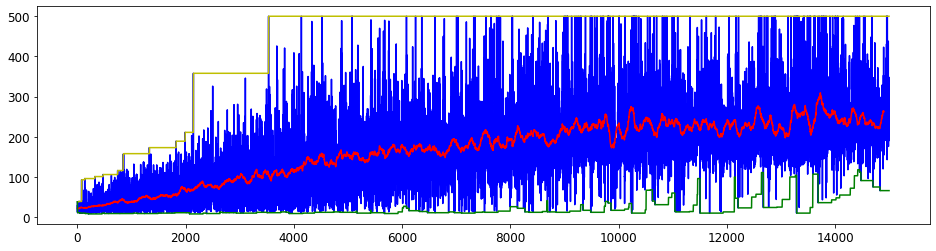

In [202]:
plt.figure(figsize=(16, 4))
#plt.plot(rewards,"b")
plt.plot(episode_reward,"b")

size = 100
y_av1 = running_mean(episode_reward, N=size)
y_av = np.insert(y_av1, np.repeat(0,size), 0)

plt.plot(y_av1,"r") 
plt.plot(maxrewards,"y") 
plt.plot(minbatchrewards,"g") 
    
print("Average:",y_av1[-10:])
print("Minimum:",minbatchrewards[-10:])

## Analysis

### Relationsship Q-learning DQN
The biggest problem with Reinforcement Learning (RL) is that the models give unstable results. For every task there need to be a lot of tewweking, and it is diffivult to figure out why some hyperparameters work or not. Also, for every run you do, you get a different result that might not be consistent with the old one.<br>
Because of this, the analysis of the given task is at the best a small guidance.<br>
<br>
The Q-model doesn't scale well as there will be too many states and actions. Therefore DQN(Deep Q-learning Network) are good to use in many cases. How should we compare Q-models with DQN and equivalent?<br>
For the Q-model, the Bellman equiation relates the Q function of consecutive steps. It is used to iteratively approxiate the Q function through temporal difference learning, and will eventually, given time, converge to an optimal state. When using a DQN, the neural network estimates the Q value (is the Q function approximator) and applies gradient descent to minimize the objective function (usualy MSE) between the estimated and target Q-value.
<br>
### Comparison
Beacuse of catastrophic forgetting (that the models forgett the good old states), we could consider to see how "little catastrophic" the models are, comparing a Q-model with a DQN.<br>
<br>
Doing that (also looking at the graphs), we look at the numbers:<br>
<b>DQN</b><br>
&nbsp;&nbsp;&nbsp; Average: [20.37 20.46 20.52 20.66 20.69 20.79 20.93 21.01 21.11 21.21]<br>
&nbsp;&nbsp;&nbsp; Minimum: [19, 18, 15, 15, 13, 13, 13, 13, 13, 13]<br>
&nbsp;&nbsp;&nbsp; Maximum (approx, out of 200): 175<br>
<br>
<b>Double DQN</b><br>
&nbsp;&nbsp;&nbsp; Average: [42.08 41.93 41.58 41.66 41.08 40.86 40.59 40.56 40.37 40.55]<br>
&nbsp;&nbsp;&nbsp; Minimum: [24, 24, 24, 24, 24, 25, 25, 25, 27, 27]<br>
&nbsp;&nbsp;&nbsp; Maximum (approx, out of 200): 135<br>
<br>
<b>Dueling Double DQN</b><br>
&nbsp;&nbsp;&nbsp; Average: [54.58 53.93 53.37 52.61 52.09 51.68 51.62 51.59 51.75 51.87]<br>
&nbsp;&nbsp;&nbsp; Minimum: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]<br>
&nbsp;&nbsp;&nbsp; Maximum (approx, out of 200): 170<br>
<br>
Nonw of the above models were very good. Comparing this to the Q-models in the G task. Here are the figures for the best Q-model.<br>
<b>Q-model</b><br>
&nbsp;&nbsp;&nbsp; Average: [328.81 329.2  329.13 327.86 325.08 323.25 325.14 324.89 323.99 322.46]<br>
&nbsp;&nbsp;&nbsp; Minimum: [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]<br>
&nbsp;&nbsp;&nbsp; Max (approx out of 500): 500<br>
<br>
Comparing Q-model with the DQNs. The Double DQN is performing better in the catastrophic scenario (27 compared to 12)
The maximum is however only 135 steps out of 200. Which would indicate that the model does not manage to balance the pole. The Q-model could do the balance act, now and then.<br>

### Seek a more stable Q-learning model
This were not satisfying results, even it was expexted do to the nature of RL. Therefore a test was made for the Q-model, taking paramters that seemed to produce "a more stable" version from a catastrophic forgetting perspecitve. 
&nbsp;&nbsp;&nbsp; LEARNING_RATE: 0.4<br>
&nbsp;&nbsp;&nbsp; GAMMA: 0.92    <br>
&nbsp;&nbsp;&nbsp; Decay: 0.0005<br>
<br><br>
<b>The Q-model gave</b><br>
&nbsp;&nbsp;&nbsp; Average: [263.   263.18 263.46 263.73 263.21 263.63 262.69 262.65 264.27 262.07]<br>
&nbsp;&nbsp;&nbsp; Minimum: [66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0]<br>
&nbsp;&nbsp;&nbsp; Max (approx out of 500): 500<br>
<br>
This is a lower average but a much higher minumum then earlier Q-models. Somewhat more stable.

### Seek a more stable DQN
And then a test was done of the Dueling Double DQN with the same goal, to make the catastrphoc forgetting better. 
We changes Esilon to be larger from the beginning. From<br>
&nbsp;&nbsp;&nbsp; epsilon = max(1 - episode / 500, 0.1)<br>
to<br>
&nbsp;&nbsp;&nbsp; epsilon = max(1 - episode / 200, 0.1)<br>
<br>
Given this the results were in both cases much better:<br>
<br>
<b>Dueling Double DQN</b><br>
&nbsp;&nbsp;&nbsp; Average: [160.12 159.8  158.88 159.64 159.84 160.52 160.8  159.4  161.12 161.8 ]<br>
&nbsp;&nbsp;&nbsp; Minimum: [149, 149, 147, 147, 147, 147, 147, 147, 147, 147]<br>
&nbsp;&nbsp;&nbsp; Maximum (approx, out of 200): 170<br>
<br>
These are both good results, and in the DD DQN case, having a worst performance of 147 steps as reward, is the best comparing all other results. <br>
The DD DQN with changed Epsilon, took however longer time to train then all other models. One reason could be that the more reward/steps an episode had, the longer the time the episode took to train, in both the Q-models and the DQN models.<br>
<br>